In [1]:
from skimage.morphology import thin
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch


cmap = mpl.colors.ListedColormap(torch.rand(256**2, 3).numpy())

def plot_segmentation_boundaries(image_np, output_mask, figsize=(15, 15)):
    """
    Plot the boundaries of the segmentation over the original image.
    Uses pixel comparison to detect boundaries and applies thinning.
    """
    output_mask_np = output_mask[0].cpu().numpy()

    # Find boundaries by comparing neighboring pixels
    boundaries = np.zeros_like(output_mask_np)
    boundaries[1:, :] = np.logical_or(boundaries[1:, :], output_mask_np[1:, :] != output_mask_np[:-1, :])  # Compare vertically
    boundaries[:, 1:] = np.logical_or(boundaries[:, 1:], output_mask_np[:, 1:] != output_mask_np[:, :-1])  # Compare horizontally

    # Apply thinning to ensure boundaries are only 1 pixel wide
    boundaries = thin(boundaries)

    fig, ax = plt.subplots(1, 1, figsize=figsize)

    ax.imshow(image_np)

    ax.contour(boundaries, colors='red', linewidths=0.7)

    ax.set_title('Image with Segmentation Boundaries (Thinned)')
    ax.axis('off')

    plt.show()
    
    
def plot_mask(mask):
    plt.figure(figsize=(10, 10))
    plt.imshow(mask[0].cpu().numpy(), cmap=cmap)
    plt.colorbar()
    plt.title('Superpixel Mask')
    plt.show()
    
def plot_gradient_map(grad_map):
    plt.figure(figsize=(10, 10))
    plt.imshow(grad_map[0, 0].cpu().numpy(), cmap='gray')
    plt.colorbar()
    plt.title('Gradient Map')
    plt.show()



In [2]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

class BSDS500Dataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.images_dir = os.path.join(root_dir, 'images', split)
        self.ground_truth_dir = os.path.join(root_dir, 'ground_truth', split)
        self.image_files = [f for f in os.listdir(self.images_dir) if f.endswith('.jpg')]
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = os.path.join(self.images_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        gt_name = os.path.join(self.ground_truth_dir, self.image_files[idx].replace('.jpg', '.mat'))
        gt_data = sio.loadmat(gt_name)
        ground_truth = gt_data['groundTruth'][0][0][0][0][1]

        
        #print(ground_truth)
        print(ground_truth.shape)
        # print(ground_truth[0, 0])
        # print(ground_truth[0, 0]['Segmentation'])
        segmentation = ground_truth
        
        if isinstance(segmentation, np.ndarray) and segmentation.shape == (1, 1):
            segmentation = segmentation[0, 0]
        
        segmentation = Image.fromarray(segmentation)
        segmentation = segmentation.resize((224, 224), Image.NEAREST)
        
        segmentation = np.array(segmentation, dtype=np.int64)

        segmentation = torch.tensor(segmentation, dtype=torch.long)
        
        return image, segmentation

transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
])

dataset = BSDS500Dataset(root_dir=r'D:\Data\BSDS500\data', split='train', transform=transform)

dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0)

import random
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

random_idx = random.randint(0, len(dataset) - 1)

image, segmentation = dataset[random_idx]

(481, 321)


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import math
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import math
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

class BoundaryPathFinder(nn.Module):
    def __init__(self, num_segments_row=8, num_segments_col=8, n_channels=3, height=224, width=224, device='cpu'):
        super(BoundaryPathFinder, self).__init__()
        
        self.num_segments_row = num_segments_row
        self.num_segments_col = num_segments_col
        self.H = height
        self.W = width
        self.device = torch.device(device)
        
        self.convert_to_grayscale = torchvision.transforms.Grayscale(num_output_channels=1)
    
    def compute_gradient_map(self, x):
        # Sobel kernels for single-channel input
        sobel_x = torch.tensor([[[[-1, 0, 1], 
                                  [-2, 0, 2], 
                                  [-1, 0, 1]]]], device=x.device, dtype=x.dtype)
        sobel_y = torch.tensor([[[[-1, -2, -1], 
                                  [0, 0, 0], 
                                  [1, 2, 1]]]], device=x.device, dtype=x.dtype)
        
        grad_x = F.conv2d(x, sobel_x, padding=1)
        grad_y = F.conv2d(x, sobel_y, padding=1)

        grad_map = torch.sqrt(grad_x.pow(2) + grad_y.pow(2) + 1e-8)
        return grad_map.squeeze(0).squeeze(0)  # Return torch tensor
    
    def initialize_grid(self):
        # Create initial grid segmentation using torch tensors
        segmentation_mask = torch.zeros((self.H, self.W), dtype=torch.int32, device=self.device)
        segment_height = self.H // self.num_segments_row
        segment_width = self.W // self.num_segments_col
        
        label = 1
        for i in range(self.num_segments_row):
            for j in range(self.num_segments_col):
                y_start = i * segment_height
                y_end = (i + 1) * segment_height if i < self.num_segments_row -1 else self.H
                x_start = j * segment_width
                x_end = (j + 1) * segment_width if j < self.num_segments_col -1 else self.W
                segmentation_mask[y_start:y_end, x_start:x_end] = label
                label += 1
        
        return segmentation_mask
    
    def adjust_boundaries(self, grad_map, segmentation_mask, band_width=5):
        """
        Adjust the boundary lines to align with the highest gradients.
        """
        H, W = segmentation_mask.shape
        
        # Initialize vertical and horizontal boundary positions
        vertical_boundaries_positions = []
        horizontal_boundaries_positions = []
        
        # Leftmost vertical boundary (x=0)
        vertical_boundaries_positions.append(torch.zeros(H, dtype=torch.int64, device=self.device))
        
        # Vertical boundaries
        for i in range(1, self.num_segments_col):
            x = i * (W // self.num_segments_col)
            x = min(x, W - 1)
            path = self.find_optimal_vertical_path(grad_map, x, band_width)
            vertical_boundaries_positions.append(path)
        
        # Rightmost vertical boundary (x=W-1)
        vertical_boundaries_positions.append(torch.full((H,), W - 1, dtype=torch.int64, device=self.device))
        
        # Topmost horizontal boundary (y=0)
        horizontal_boundaries_positions.append(torch.zeros(W, dtype=torch.int64, device=self.device))
        
        # Horizontal boundaries
        for i in range(1, self.num_segments_row):
            y = i * (H // self.num_segments_row)
            y = min(y, H - 1)
            path = self.find_optimal_horizontal_path(grad_map, y, band_width)
            horizontal_boundaries_positions.append(path)
        
        # Bottommost horizontal boundary (y=H-1)
        horizontal_boundaries_positions.append(torch.full((W,), H - 1, dtype=torch.int64, device=self.device))
        
        # Create boundary mask
        boundary_mask = torch.zeros_like(segmentation_mask, dtype=torch.bool, device=self.device)
        
        # Mark vertical boundaries
        for path in vertical_boundaries_positions[1:-1]:  # Exclude leftmost and rightmost boundaries
            for y in range(H):
                x = path[y]
                boundary_mask[y, x] = True
        
        # Mark horizontal boundaries
        for path in horizontal_boundaries_positions[1:-1]:  # Exclude topmost and bottommost boundaries
            for x in range(W):
                y = path[x]
                boundary_mask[y, x] = True
        
        # Use connected components labeling to get new segmentation mask
        # Since PyTorch doesn't have connected components labeling, we'll use scipy and convert the result back to torch tensor
        boundary_mask_np = boundary_mask.cpu().numpy()
        from scipy.ndimage import label
        labeled_array_np, num_features = label(~boundary_mask_np)
        labeled_array = torch.from_numpy(labeled_array_np).to(self.device)
        
        return labeled_array
    
    def find_optimal_vertical_path(self, grad_map, initial_x, band_width):
        """
        Find the optimal vertical path (top to bottom) around the initial_x position.
        """
        H, W = grad_map.shape
        band_positions = torch.arange(-band_width, band_width + 1, device=self.device)
        x_indices = initial_x + band_positions
        x_indices = torch.clamp(x_indices, 0, W - 1)
        num_positions = x_indices.numel()
        
        cost = torch.full((H, num_positions), float('inf'), device=self.device)
        path = torch.zeros((H, num_positions), dtype=torch.int64, device=self.device)
        
        # Initialize the first row
        cost[0, :] = -grad_map[0, x_indices]
        
        for y in range(1, H):
            for idx in range(num_positions):
                x = x_indices[idx]
                min_cost = float('inf')
                min_idx = -1
                for k in [-1, 0, 1]:
                    prev_idx = idx + k
                    if 0 <= prev_idx < num_positions:
                        c = cost[y - 1, prev_idx]
                        if c < min_cost:
                            min_cost = c
                            min_idx = prev_idx
                cost[y, idx] = min_cost - grad_map[y, x]
                path[y, idx] = min_idx
        
        # Backtrack to find the optimal path
        min_end_idx = torch.argmin(cost[-1, :]).item()
        optimal_path = torch.zeros(H, dtype=torch.int64, device=self.device)
        idx = min_end_idx
        for y in reversed(range(H)):
            x = x_indices[idx]
            optimal_path[y] = x
            idx = path[y, idx]
        
        return optimal_path
    
    def find_optimal_horizontal_path(self, grad_map, initial_y, band_width):
        """
        Find the optimal horizontal path (left to right) around the initial_y position.
        """
        H, W = grad_map.shape
        band_positions = torch.arange(-band_width, band_width + 1, device=self.device)
        y_indices = initial_y + band_positions
        y_indices = torch.clamp(y_indices, 0, H - 1)
        num_positions = y_indices.numel()
        
        cost = torch.full((W, num_positions), float('inf'), device=self.device)
        path = torch.zeros((W, num_positions), dtype=torch.int64, device=self.device)
        
        # Initialize the first column
        cost[0, :] = -grad_map[y_indices, 0]
        
        for x in range(1, W):
            for idx in range(num_positions):
                y = y_indices[idx]
                min_cost = float('inf')
                min_idx = -1
                for k in [-1, 0, 1]:
                    prev_idx = idx + k
                    if 0 <= prev_idx < num_positions:
                        c = cost[x - 1, prev_idx]
                        if c < min_cost:
                            min_cost = c
                            min_idx = prev_idx
                cost[x, idx] = min_cost - grad_map[y, x]
                path[x, idx] = min_idx
        
        # Backtrack to find the optimal path
        min_end_idx = torch.argmin(cost[-1, :]).item()
        optimal_path = torch.zeros(W, dtype=torch.int64, device=self.device)
        idx = min_end_idx
        for x in reversed(range(W)):
            y = y_indices[idx]
            optimal_path[x] = y
            idx = path[x, idx]
        
        return optimal_path
    
    def forward(self, x):
        B, C_in, H, W = x.shape
        assert B == 1, "Batch size must be 1."
        if C_in == 3:
            grayscale_image = self.convert_to_grayscale(x)
        else:
            grayscale_image = x
        
        # Compute gradient map
        grad_map = self.compute_gradient_map(grayscale_image)
        
        # Initialize grid segmentation
        segmentation_mask = self.initialize_grid()
        
        # Adjust boundaries to align with highest gradients
        new_segmentation_mask = self.adjust_boundaries(grad_map, segmentation_mask)
        
        return grad_map, segmentation_mask, new_segmentation_mask


# Visualization Function
def visualize_results(input_image, grad_map, initial_segmentation, final_segmentation):
    """
    Visualize the original image, gradient map, initial segmentation, and final segmentation.
    """
    # Convert tensors to numpy arrays
    input_image_np = input_image.squeeze(0).permute(1, 2, 0).cpu().numpy()
    
    # Normalize gradient map for visualization
    grad_map_norm = (grad_map - grad_map.min()) / (grad_map.max() - grad_map.min())
    
    # Create color maps for segmentation masks
    initial_mask_color = color_segmentation(initial_segmentation)
    final_mask_color = color_segmentation(final_segmentation)
    
    # Overlay boundaries on the original image
    initial_boundary = find_boundaries(initial_segmentation)
    final_boundary = find_boundaries(final_segmentation)
    overlay_initial = input_image_np.copy()
    overlay_initial[initial_boundary] = [1.0, 0, 0]  # Red color for boundaries
    overlay_final = input_image_np.copy()
    overlay_final[final_boundary] = [1.0, 0, 0]  # Red color for boundaries

    # Plotting
    fig, axes = plt.subplots(2, 3, figsize=(25, 17))
    axes = axes.ravel()
    titles = ['Original Image', 'Gradient Map', 'Initial Segmentation', 
              'Final Segmentation', 'Initial Boundaries', 'Final Boundaries']
    images = [input_image_np, grad_map_norm, initial_mask_color, 
              final_mask_color, overlay_initial, overlay_final]

    for ax, img, title in zip(axes, images, titles):
        if img.ndim == 2 or img.shape[2] == 1:  # Grayscale
            ax.imshow(img, cmap='gray')
        else:
            ax.imshow(img, cmap=mpl.colors.ListedColormap(torch.rand(256**2,3).numpy()))
        ax.set_title(title)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

def color_segmentation(segmentation_mask):
    """
    Assign random colors to each segment for visualization.
    """
    num_labels = segmentation_mask.max() + 1
    colors = np.random.rand(num_labels + 1, 3)
    colors[0] = 0  # Background color
    colored_mask = colors[segmentation_mask]
    return colored_mask

def find_boundaries(segmentation_mask):
    """
    Find boundaries in the segmentation mask.
    """
    from scipy.ndimage import generic_filter

    def boundary_func(values):
        center = values[4]
        return not np.all(values == center)

    footprint = np.array([[1,1,1],
                          [1,1,1],
                          [1,1,1]])
    boundaries = generic_filter(segmentation_mask, boundary_func, footprint=footprint)
    return boundaries.astype(bool)


device = "cpu"
input_image = image.to(device)

# model = BoundaryPathFinder(num_segments_row=16, num_segments_col=16, n_channels=3, height=224, width=224, device=device)
# print(input_image.shape)
# grad_map, initial_segmentation, final_segmentation = model(input_image.unsqueeze(0))

# print
# print(input_image.shape, grad_map.shape, initial_segmentation.shape, final_segmentation.shape)
# visualize_results(input_image, grad_map, initial_segmentation, final_segmentation)


301 256
torch.Size([3, 224, 224]) torch.Size([1, 1, 224, 224]) torch.Size([1, 224, 224]) torch.Size([1, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


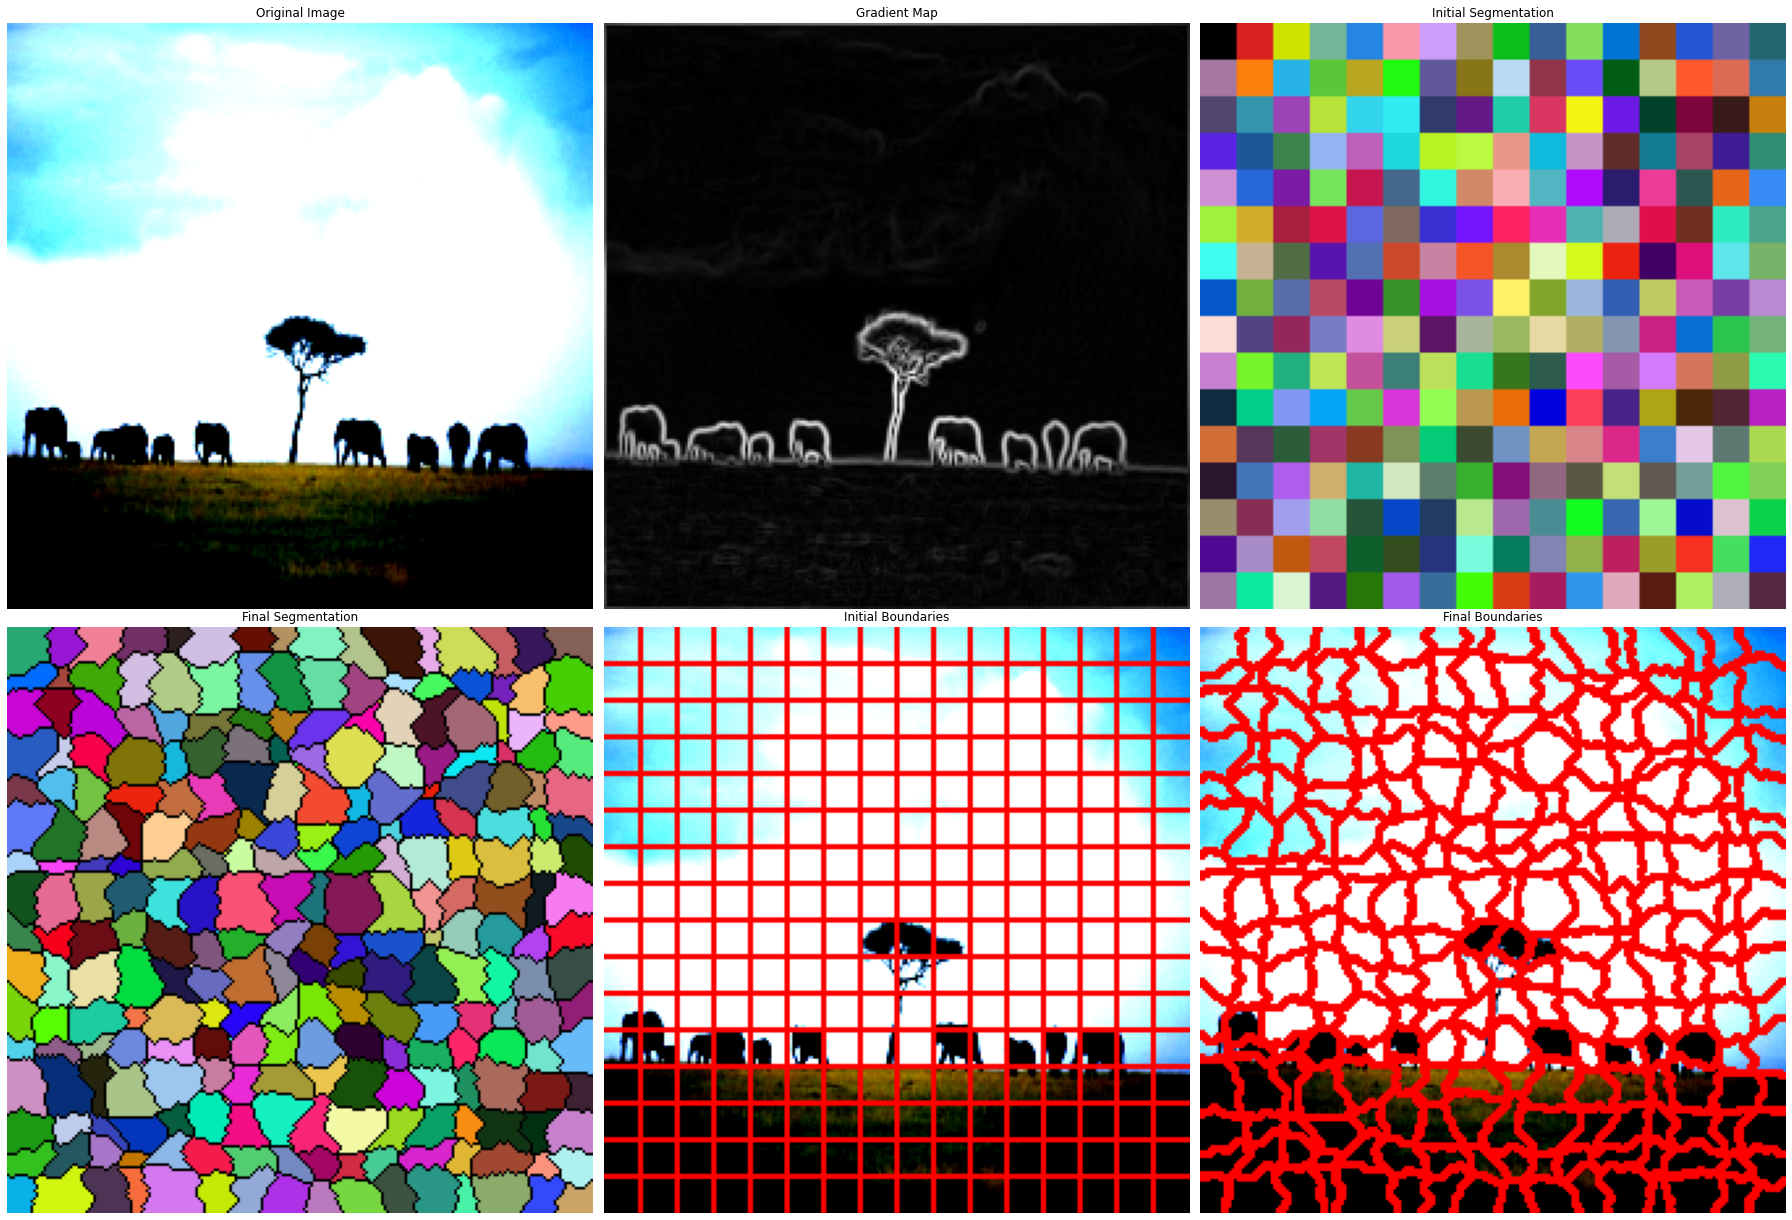

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

class BoundaryPathFinder2(nn.Module):
    def __init__(self, num_segments_row=8, num_segments_col=8, height=224, width=224, device='cpu'):
        super(BoundaryPathFinder2, self).__init__()
        
        self.num_segments_row = num_segments_row
        self.num_segments_col = num_segments_col
        self.H = height
        self.W = width
        self.device = device
        
        self.convert_to_grayscale = torchvision.transforms.Grayscale(num_output_channels=1)
    
    def compute_gradient_map(self, x):
        # x: (B, C, H, W)
        if x.shape[1] == 3:
            x = self.convert_to_grayscale(x)
        
        # Sobel kernels
        sobel_x = torch.tensor([[[[-1, 0, 1], 
                                  [-2, 0, 2], 
                                  [-1, 0, 1]]]], device=x.device, dtype=x.dtype)
        sobel_y = torch.tensor([[[[-1, -2, -1], 
                                  [0, 0, 0], 
                                  [1, 2, 1]]]], device=x.device, dtype=x.dtype)
        
        # Apply Sobel filters
        grad_x = F.conv2d(x, sobel_x, padding=1)
        grad_y = F.conv2d(x, sobel_y, padding=1)

        # Compute gradient magnitude
        grad_map = torch.sqrt(grad_x ** 2 + grad_y ** 2 + 1e-8)
        return grad_map  # Shape: (B, 1, H, W)
    
    def initialize_grid(self, batch_size):
        # Create initial grid segmentation
        # Output shape: (B, H, W)
        segment_height = self.H // self.num_segments_row
        segment_width = self.W // self.num_segments_col

        # Create grid labels
        rows = torch.arange(self.H, device=self.device).unsqueeze(1).expand(self.H, self.W)
        cols = torch.arange(self.W, device=self.device).unsqueeze(0).expand(self.H, self.W)

        row_labels = rows // segment_height
        col_labels = cols // segment_width

        labels = (row_labels * self.num_segments_col + col_labels).to(torch.int32)
        labels = labels.unsqueeze(0).expand(batch_size, -1, -1)  # Shape: (B, H, W)

        return labels
    
    def adjust_boundaries(self, grad_map, segmentation_mask, band_width=5):
        """
        Adjust boundary lines to align with the highest gradients.
        """
        B, H, W = segmentation_mask.shape
        device = grad_map.device

        # Prepare indices
        y_indices = torch.arange(H, device=device)
        x_indices = torch.arange(W, device=device)

        # Initialize boundary masks
        boundary_masks = torch.zeros((B, H, W), dtype=torch.bool, device=device)

        # Process each image in the batch
        for b in range(B):
            grad_map_b = grad_map[b, 0]  # Shape: (H, W)

            # Vertical boundaries
            vertical_paths = []
            for i in range(1, self.num_segments_col):
                x_init = i * (W // self.num_segments_col)
                x_init = min(x_init, W - 1)
                path = self.find_optimal_vertical_path(grad_map_b, x_init, band_width)
                vertical_paths.append(path)

            # Mark vertical boundaries
            for path in vertical_paths:
                boundary_masks[b, y_indices, path] = True

            # Horizontal boundaries
            horizontal_paths = []
            for i in range(1, self.num_segments_row):
                y_init = i * (H // self.num_segments_row)
                y_init = min(y_init, H - 1)
                path = self.find_optimal_horizontal_path(grad_map_b, y_init, band_width)
                horizontal_paths.append(path)

            # Mark horizontal boundaries
            for path in horizontal_paths:
                boundary_masks[b, path, x_indices] = True

        # Use connected components labeling
        from skimage.measure import label as skimage_label

        new_segmentation_masks = []
        for b in range(B):
            boundary_mask_np = boundary_masks[b].cpu().numpy()
            labeled_array = skimage_label(~boundary_mask_np, connectivity=1)
            new_segmentation_masks.append(torch.from_numpy(labeled_array).to(device))

        new_segmentation_masks = torch.stack(new_segmentation_masks, dim=0).to(torch.int32)

        return new_segmentation_masks  # Shape: (B, H, W)
    
    def find_optimal_vertical_path(self, grad_map, x_init, band_width):
        """
        Find optimal vertical path around the initial x position.
        """
        H, W = grad_map.shape
        device = grad_map.device

        # Define band around x_init
        x_indices = x_init + torch.arange(-band_width, band_width + 1, device=device)
        x_indices = x_indices.clamp(0, W - 1)
        num_positions = x_indices.size(0)

        # Initialize cost and path matrices
        cost = torch.full((H, num_positions), float('inf'), device=device)
        path = torch.zeros((H, num_positions), dtype=torch.long, device=device)

        # First row
        cost[0] = -grad_map[0, x_indices]

        # Dynamic programming
        for y in range(1, H):
            prev_cost = cost[y - 1]
            prev_indices = torch.stack([
                torch.arange(num_positions, device=device).clamp(0, num_positions - 1),
                (torch.arange(num_positions, device=device) - 1).clamp(0, num_positions - 1),
                (torch.arange(num_positions, device=device) + 1).clamp(0, num_positions - 1)
            ], dim=1)
            prev_costs = prev_cost[prev_indices]
            min_prev_costs, min_indices = prev_costs.min(dim=1)
            cost[y] = min_prev_costs - grad_map[y, x_indices]
            path[y] = prev_indices[torch.arange(num_positions, device=device), min_indices]

        # Backtracking
        idx = cost[-1].argmin().item()
        optimal_path = []
        for y in reversed(range(H)):
            optimal_path.append(x_indices[idx])
            idx = path[y, idx].item()
        optimal_path.reverse()
        optimal_path = torch.stack(optimal_path)
        return optimal_path  # Shape: (H,)
    
    def find_optimal_horizontal_path(self, grad_map, y_init, band_width):
        """
        Find optimal horizontal path around the initial y position.
        """
        H, W = grad_map.shape
        device = grad_map.device

        # Define band around y_init
        y_indices = y_init + torch.arange(-band_width, band_width + 1, device=device)
        y_indices = y_indices.clamp(0, H - 1)
        num_positions = y_indices.size(0)

        # Initialize cost and path matrices
        cost = torch.full((W, num_positions), float('inf'), device=device)
        path = torch.zeros((W, num_positions), dtype=torch.long, device=device)

        # First column
        cost[0] = -grad_map[y_indices, 0]

        # Dynamic programming
        for x in range(1, W):
            prev_cost = cost[x - 1]
            prev_indices = torch.stack([
                torch.arange(num_positions, device=device).clamp(0, num_positions - 1),
                (torch.arange(num_positions, device=device) - 1).clamp(0, num_positions - 1),
                (torch.arange(num_positions, device=device) + 1).clamp(0, num_positions - 1)
            ], dim=1)
            prev_costs = prev_cost[prev_indices]
            min_prev_costs, min_indices = prev_costs.min(dim=1)
            cost[x] = min_prev_costs - grad_map[y_indices, x]
            path[x] = prev_indices[torch.arange(num_positions, device=device), min_indices]

        # Backtracking
        idx = cost[-1].argmin().item()
        optimal_path = []
        for x in reversed(range(W)):
            optimal_path.append(y_indices[idx])
            idx = path[x, idx].item()
        optimal_path.reverse()
        optimal_path = torch.stack(optimal_path)
        return optimal_path  # Shape: (W,)
    
    def forward(self, x):
        B, C, H, W = x.shape
        if H != self.H or W != self.W:
            raise ValueError(f"Input image size must match initialized size: ({self.H}, {self.W})")

        # Compute gradient map
        grad_map = self.compute_gradient_map(x)  # Shape: (B, 1, H, W)

        # Initialize grid segmentation
        segmentation_mask = self.initialize_grid(B)  # Shape: (B, H, W)

        # Adjust boundaries
        new_segmentation_mask = self.adjust_boundaries(grad_map, segmentation_mask)

        return grad_map, segmentation_mask, new_segmentation_mask
    
model2 = BoundaryPathFinder2(num_segments_row=16, num_segments_col=16, height=224, width=224, device=device)
grad_map, initial_segmentation, final_segmentation = model2(input_image.unsqueeze(0))
unique_values = torch.unique(final_segmentation)
unque_values_initial = torch.unique(initial_segmentation)
# Get the number of unique values
num_unique_initial = unque_values_initial.numel()
num_unique_values = unique_values.numel()
print(num_unique_values, num_unique_initial)
print(input_image.shape, grad_map.shape, initial_segmentation.shape, final_segmentation.shape)
visualize_results(input_image.squeeze(0), grad_map.squeeze(0).squeeze(0), initial_segmentation.squeeze(0), final_segmentation.squeeze(0))


torch.Size([3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


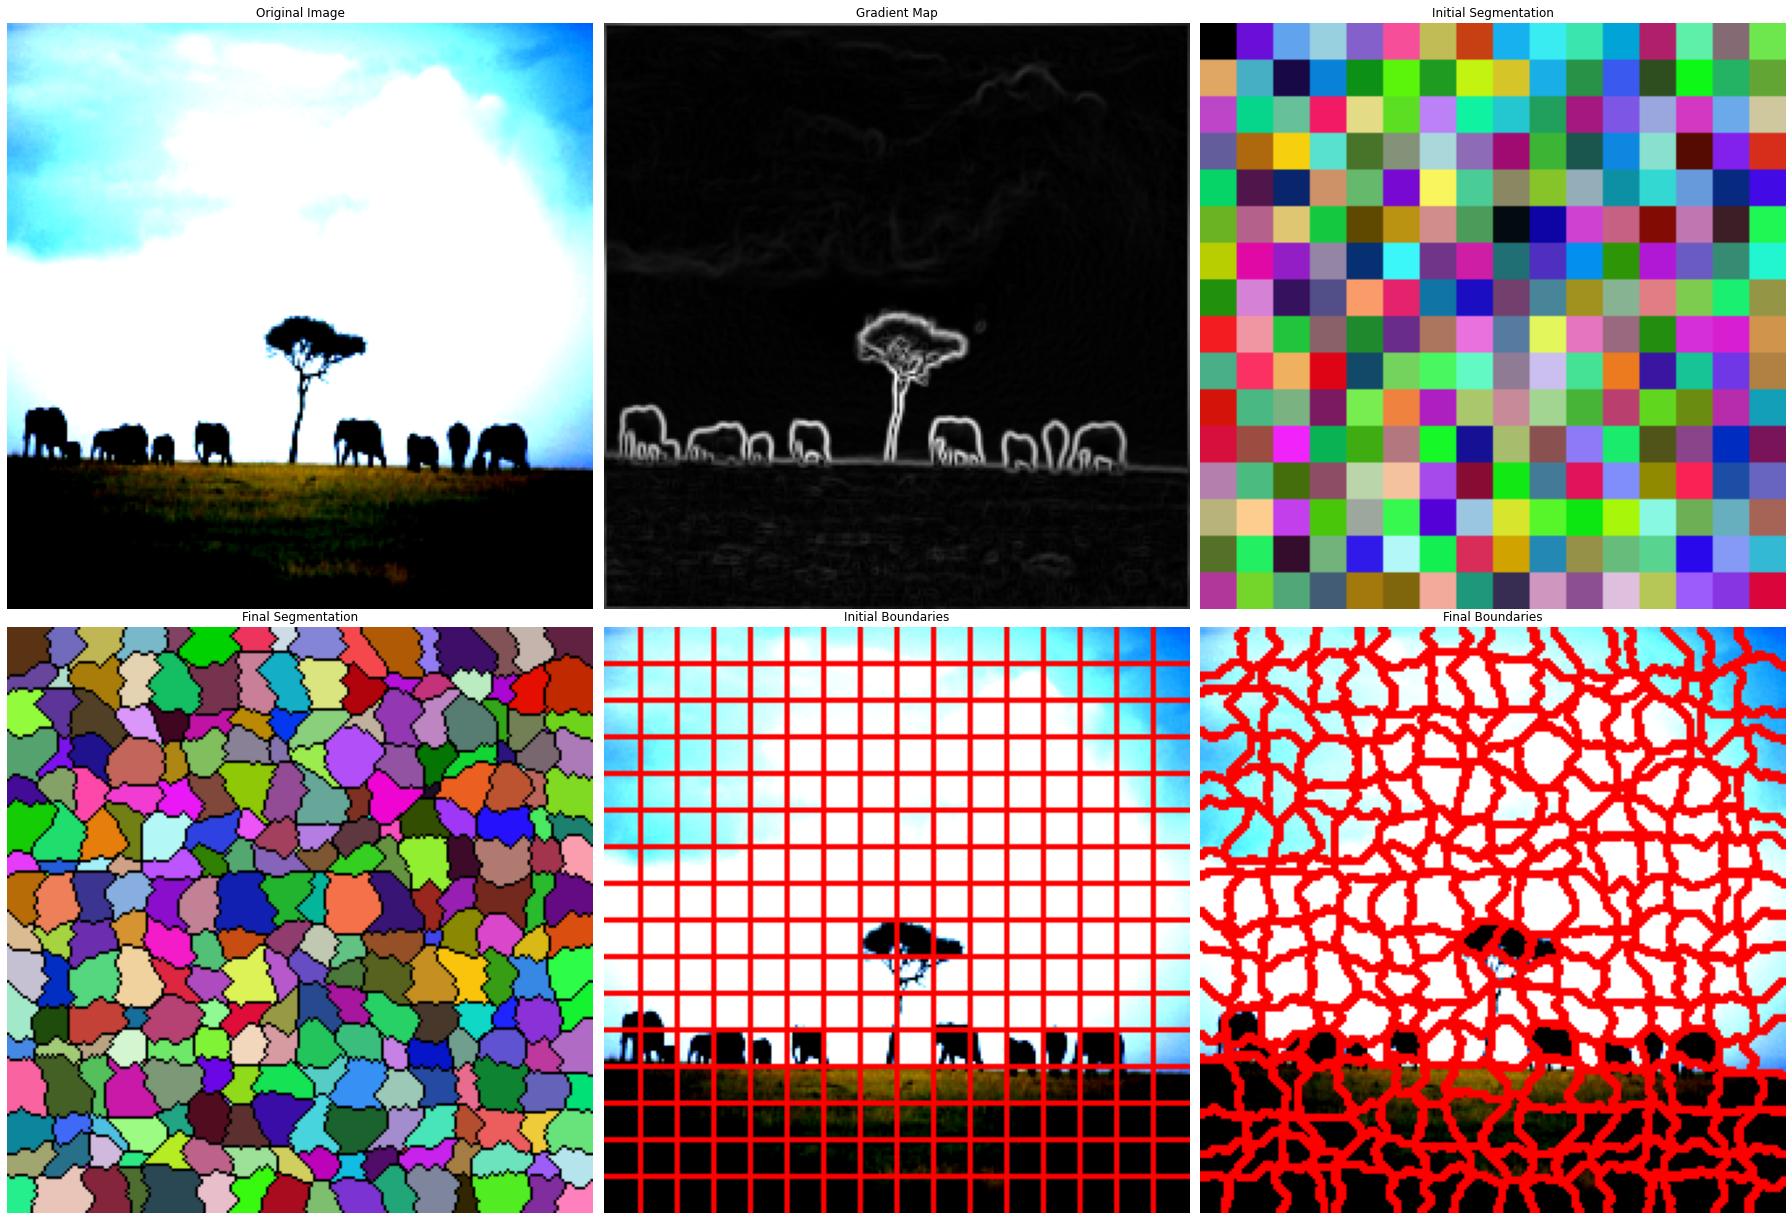

In [5]:
model2 = BoundaryPathFinder2(num_segments_row=16, num_segments_col=16, height=224, width=224, device=device)
print(input_image.shape)
grad_map, initial_segmentation, final_segmentation = model2(input_image.unsqueeze(0))
visualize_results(input_image.squeeze(0), grad_map.squeeze(0).squeeze(0), initial_segmentation.squeeze(0), final_segmentation.squeeze(0))



In [6]:
def explained_variance_batch(image_batch, superpixel_labels_batch):
    batch_size, num_channels, height, width = image_batch.shape
    explained_variance_scores = []

    for i in range(batch_size):
        image = image_batch[i]  # Shape: (C, H, W)
        superpixel_labels = superpixel_labels_batch[i]  # Shape: (H, W)

        # Ensure superpixel_labels is in shape (H, W)
        superpixel_labels = superpixel_labels.squeeze().to(image.device)

        # Flatten image and labels for computation
        image_flat = image.view(num_channels, height * width)
        labels_flat = superpixel_labels.view(height * width)

        # Compute total variance of the image across all channels
        total_variance = image_flat.var(dim=1, unbiased=False).mean().item()

        # Proceed to compute within-superpixel variance (homogeneity_score)
        unique_labels = superpixel_labels.unique()
        num_superpixels = unique_labels.size(0)

        pixel_sums = torch.zeros((num_superpixels, num_channels), device=image.device)
        pixel_squares = torch.zeros((num_superpixels, num_channels), device=image.device)
        pixel_counts = torch.zeros(num_superpixels, device=image.device)

        for j, label in enumerate(unique_labels):
            mask = (labels_flat == label)
            pixel_sums[j] = image_flat[:, mask].sum(dim=1)
            pixel_squares[j] = (image_flat[:, mask] ** 2).sum(dim=1)
            pixel_counts[j] = mask.sum()

        pixel_means = pixel_sums / pixel_counts.unsqueeze(1)
        pixel_variances = (pixel_squares / pixel_counts.unsqueeze(1)) - (pixel_means ** 2)
        within_variance = pixel_variances.mean().item()

        # Compute explained variance
        explained_variance = 1 - (within_variance / total_variance)
        explained_variance_scores.append(explained_variance)

    return explained_variance_scores


grad_map, initial_segmentation, final_segmentation = model2(input_image.unsqueeze(0))
unique_values = torch.unique(final_segmentation)
# Get the number of unique values
num_unique_values = unique_values.numel()
print(num_unique_values)
explained_variance_batch(image.unsqueeze(0), final_segmentation)

301


[0.9618408426187757]

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

class BoundaryPathFinder2(nn.Module):
    def __init__(self, num_segments_row=8, num_segments_col=8, height=224, width=224, device='cpu'):
        super(BoundaryPathFinder2, self).__init__()
        
        self.num_segments_row = num_segments_row
        self.num_segments_col = num_segments_col
        self.H = height
        self.W = width
        self.device = device
        
        self.convert_to_grayscale = torchvision.transforms.Grayscale(num_output_channels=1)
    
    def compute_gradient_map(self, x):
        # x: (B, C, H, W)
        if x.shape[1] == 3:
            x = self.convert_to_grayscale(x)
        
        # Sobel kernels
        sobel_x = torch.tensor([[[[-1, 0, 1], 
                                  [-2, 0, 2], 
                                  [-1, 0, 1]]]], device=x.device, dtype=x.dtype)
        sobel_y = torch.tensor([[[[-1, -2, -1], 
                                  [0, 0, 0], 
                                  [1, 2, 1]]]], device=x.device, dtype=x.dtype)
        
        # Apply Sobel filters
        grad_x = F.conv2d(x, sobel_x, padding=1)
        grad_y = F.conv2d(x, sobel_y, padding=1)

        # Compute gradient magnitude
        grad_map = torch.sqrt(grad_x ** 2 + grad_y ** 2 + 1e-8)
        return grad_map  # Shape: (B, 1, H, W)
    
    def initialize_grid(self, batch_size):
        # Create initial grid segmentation
        # Output shape: (B, H, W)
        segment_height = self.H // self.num_segments_row
        segment_width = self.W // self.num_segments_col

        # Create grid labels
        rows = torch.arange(self.H, device=self.device).unsqueeze(1).expand(self.H, self.W)
        cols = torch.arange(self.W, device=self.device).unsqueeze(0).expand(self.H, self.W)

        row_labels = rows // segment_height
        col_labels = cols // segment_width

        labels = (row_labels * self.num_segments_col + col_labels).to(torch.int32)
        labels = labels.unsqueeze(0).expand(batch_size, -1, -1)  # Shape: (B, H, W)

        return labels
    
    def fill_boundaries(self, segmentation_mask):
        """
        Fill boundary pixels with the labels of neighboring pixels using morphological dilation.
        """
        B, H, W = segmentation_mask.shape
        device = segmentation_mask.device

        # Convert segmentation mask to numpy for processing
        segmentation_mask_np = segmentation_mask.cpu().numpy()

        from scipy.ndimage import morphology

        new_segmentation_masks = []

        for b in range(B):
            mask = segmentation_mask_np[b]

            # Create a mask of boundary pixels (label == 0)
            boundary_pixels = (mask == 0)

            # Perform morphological dilation to fill boundary pixels
            filled_mask = morphology.grey_dilation(mask, size=(3, 3), structure=np.ones((3, 3)), mode='nearest')
            filled_mask[~boundary_pixels] = mask[~boundary_pixels]  # Keep original labels where not boundary

            new_segmentation_masks.append(torch.from_numpy(filled_mask).to(device))

        new_segmentation_masks = torch.stack(new_segmentation_masks, dim=0).to(torch.int32)

        return new_segmentation_masks
    
    def adjust_boundaries(self, grad_map, segmentation_mask, band_width=5):
        """
        Adjust boundary lines to align with the highest gradients while preserving initial labels.
        """
        B, H, W = segmentation_mask.shape
        device = grad_map.device

        # Prepare indices
        y_indices = torch.arange(H, device=device)
        x_indices = torch.arange(W, device=device)

        # Initialize boundary masks
        boundary_masks = torch.zeros((B, H, W), dtype=torch.bool, device=device)

        # Process each image in the batch
        for b in range(B):
            grad_map_b = grad_map[b, 0]  # Shape: (H, W)
            segmentation_mask_b = segmentation_mask[b]

            # Vertical boundaries
            vertical_paths = []
            for i in range(1, self.num_segments_col):
                x_init = i * (W // self.num_segments_col)
                x_init = min(x_init, W - 1)
                path = self.find_optimal_vertical_path(grad_map_b, x_init, band_width)
                vertical_paths.append(path)

            # Mark vertical boundaries
            for path in vertical_paths:
                boundary_masks[b, y_indices, path] = True

            # Horizontal boundaries
            horizontal_paths = []
            for i in range(1, self.num_segments_row):
                y_init = i * (H // self.num_segments_row)
                y_init = min(y_init, H - 1)
                path = self.find_optimal_horizontal_path(grad_map_b, y_init, band_width)
                horizontal_paths.append(path)

            # Mark horizontal boundaries
            for path in horizontal_paths:
                boundary_masks[b, path, x_indices] = True

        # Update segmentation mask
        # Set boundary pixels to a special label (e.g., 0)
        segmentation_mask_b[boundary_masks[b]] = 0

        # Fill boundary pixels
        new_segmentation_mask = self.fill_boundaries(segmentation_mask, grad_map)

        return new_segmentation_mask  # Shape: (B, H, W)
    
    def find_optimal_vertical_path(self, grad_map, x_init, band_width):
        """
        Find optimal vertical path around the initial x position.
        """
        H, W = grad_map.shape
        device = grad_map.device

        # Define band around x_init
        x_indices = x_init + torch.arange(-band_width, band_width + 1, device=device)
        x_indices = x_indices.clamp(0, W - 1)
        num_positions = x_indices.size(0)

        # Initialize cost and path matrices
        cost = torch.full((H, num_positions), float('inf'), device=device)
        path = torch.zeros((H, num_positions), dtype=torch.long, device=device)

        # First row
        cost[0] = -grad_map[0, x_indices]

        # Dynamic programming
        for y in range(1, H):
            prev_cost = cost[y - 1]
            prev_indices = torch.stack([
                torch.arange(num_positions, device=device).clamp(0, num_positions - 1),
                (torch.arange(num_positions, device=device) - 1).clamp(0, num_positions - 1),
                (torch.arange(num_positions, device=device) + 1).clamp(0, num_positions - 1)
            ], dim=1)
            prev_costs = prev_cost[prev_indices]
            min_prev_costs, min_indices = prev_costs.min(dim=1)
            cost[y] = min_prev_costs - grad_map[y, x_indices]
            path[y] = prev_indices[torch.arange(num_positions, device=device), min_indices]

        # Backtracking
        idx = cost[-1].argmin().item()
        optimal_path = []
        for y in reversed(range(H)):
            optimal_path.append(x_indices[idx])
            idx = path[y, idx].item()
        optimal_path.reverse()
        optimal_path = torch.stack(optimal_path)
        return optimal_path  # Shape: (H,)
    
    def find_optimal_horizontal_path(self, grad_map, y_init, band_width):
        """
        Find optimal horizontal path around the initial y position.
        """
        H, W = grad_map.shape
        device = grad_map.device

        # Define band around y_init
        y_indices = y_init + torch.arange(-band_width, band_width + 1, device=device)
        y_indices = y_indices.clamp(0, H - 1)
        num_positions = y_indices.size(0)

        # Initialize cost and path matrices
        cost = torch.full((W, num_positions), float('inf'), device=device)
        path = torch.zeros((W, num_positions), dtype=torch.long, device=device)

        # First column
        cost[0] = -grad_map[y_indices, 0]

        # Dynamic programming
        for x in range(1, W):
            prev_cost = cost[x - 1]
            prev_indices = torch.stack([
                torch.arange(num_positions, device=device).clamp(0, num_positions - 1),
                (torch.arange(num_positions, device=device) - 1).clamp(0, num_positions - 1),
                (torch.arange(num_positions, device=device) + 1).clamp(0, num_positions - 1)
            ], dim=1)
            prev_costs = prev_cost[prev_indices]
            min_prev_costs, min_indices = prev_costs.min(dim=1)
            cost[x] = min_prev_costs - grad_map[y_indices, x]
            path[x] = prev_indices[torch.arange(num_positions, device=device), min_indices]

        # Backtracking
        idx = cost[-1].argmin().item()
        optimal_path = []
        for x in reversed(range(W)):
            optimal_path.append(y_indices[idx])
            idx = path[x, idx].item()
        optimal_path.reverse()
        optimal_path = torch.stack(optimal_path)
        return optimal_path  # Shape: (W,)
    
    def forward(self, x):
        B, C, H, W = x.shape
        if H != self.H or W != self.W:
            raise ValueError(f"Input image size must match initialized size: ({self.H}, {self.W})")

        # Compute gradient map
        grad_map = self.compute_gradient_map(x)  # Shape: (B, 1, H, W)

        # Initialize grid segmentation
        segmentation_mask = self.initialize_grid(B)  # Shape: (B, H, W)

        # Adjust boundaries
        new_segmentation_mask = self.adjust_boundaries(grad_map, segmentation_mask)

        return grad_map, segmentation_mask, new_segmentation_mask

device = 'cpu'
model2 = BoundaryPathFinder2(num_segments_row=16, num_segments_col=16, height=224, width=224, device=device)
grad_map, initial_segmentation, final_segmentation = model2(input_image.unsqueeze(0))
unique_values = torch.unique(final_segmentation)
unque_values_initial = torch.unique(initial_segmentation)
# Get the number of unique values
num_unique_initial = unque_values_initial.numel()
num_unique_values = unique_values.numel()
print(num_unique_values, num_unique_initial)
print(input_image.shape, grad_map.shape, initial_segmentation.shape, final_segmentation.shape)
visualize_results(input_image.squeeze(0), grad_map.squeeze(0).squeeze(0), initial_segmentation.squeeze(0), final_segmentation.squeeze(0))


TypeError: fill_boundaries() takes 2 positional arguments but 3 were given